<a href="https://colab.research.google.com/github/tonywang1990/mini-rl/blob/main/td_double_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install gym[toy_text]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3132 sha256=e895330cd066fc2e284fc7c16138054b07c9aaf551defb1805d605a42ffa51d3
  Stored in directory: /root/.cache/pip/wheels/f1/0a/2a/86955ea711b461ab7918236fed2568733f75ed677d0524b56c
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 4.1 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=675005bb7a7f85e5ad783416b795ffc5fd1373c0b8b88301a9064d5264cd2e9d
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2

In [3]:
# Setup Environment
import gym
from colabgymrender.recorder import Recorder
from typing import List, Set, Dict, Tuple, Optional
import numpy as np
from tqdm import tqdm
import os 
import numpy.ma as ma
from numpy.core.getlimits import inf
from collections import defaultdict
from gym.spaces import Space, Discrete
import random 
import matplotlib.pyplot as plt

os.environ["SDL_VIDEODRIVER"] = "dummy"

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2056192/45929032 bytes (4.5%)4325376/45929032 bytes (9.4%)6856704/45929032 bytes (14.9%)9478144/45929032 bytes (20.6%)11001856/45929032 bytes (24.0%)13484032/45929032 bytes (29.4%)15425536/45929032 bytes (33.6%)18096128/45929032 bytes (39.4%)19832832/45929032 bytes (43.2%)22192128/45929032 bytes (48.3%)24387584/45929032 bytes (53.1%)26689536/45929032 bytes (58.1%)280

In [4]:
class Agent(object):
  def __init__(self, state_space: Space, action_space: Space, discount_rate: float):
    self._state_spacee = state_space
    self._action_space = action_space
    self._discount_rate = discount_rate
    self._prev_action = None
    self._prev_state = None

In [5]:
# Utils
def get_epsilon_greedy_policy_from_action_values(action_values : np.array, epsilon: Optional[float] = 0.0) -> np.array:
  optimal_actions = np.argmax(action_values, axis=-1)
  num_actions = action_values.shape[-1]
  policy = np.full(action_values.shape, epsilon / num_actions)
  if optimal_actions.ndim == 0:
    policy[optimal_actions] += 1.0 - epsilon
  elif optimal_actions.ndim == 1:
    for i, j in enumerate(optimal_actions):
      policy[i, j] += 1.0 - epsilon
  else:
    raise NotImplementedError
  return policy

def get_state_values_from_action_values(action_values : np.array, policy: Optional[np.array] = None) -> np.array:
  if policy is None:
    #assume greedy policy
    policy = get_epsilon_greedy_policy_from_action_values(action_values)
  state_values = np.sum(action_values * policy, axis=1)
  return state_values

def plot_history(history: list):
  plt.figure(0, figsize=(16,4))
  plt.title("average reward per step")
  history_smoothed = [np.mean(history[max(0, i-max_episode//10): i+1]) for i in range(len(history))]
  plt.plot(history)
  plt.plot(history_smoothed)




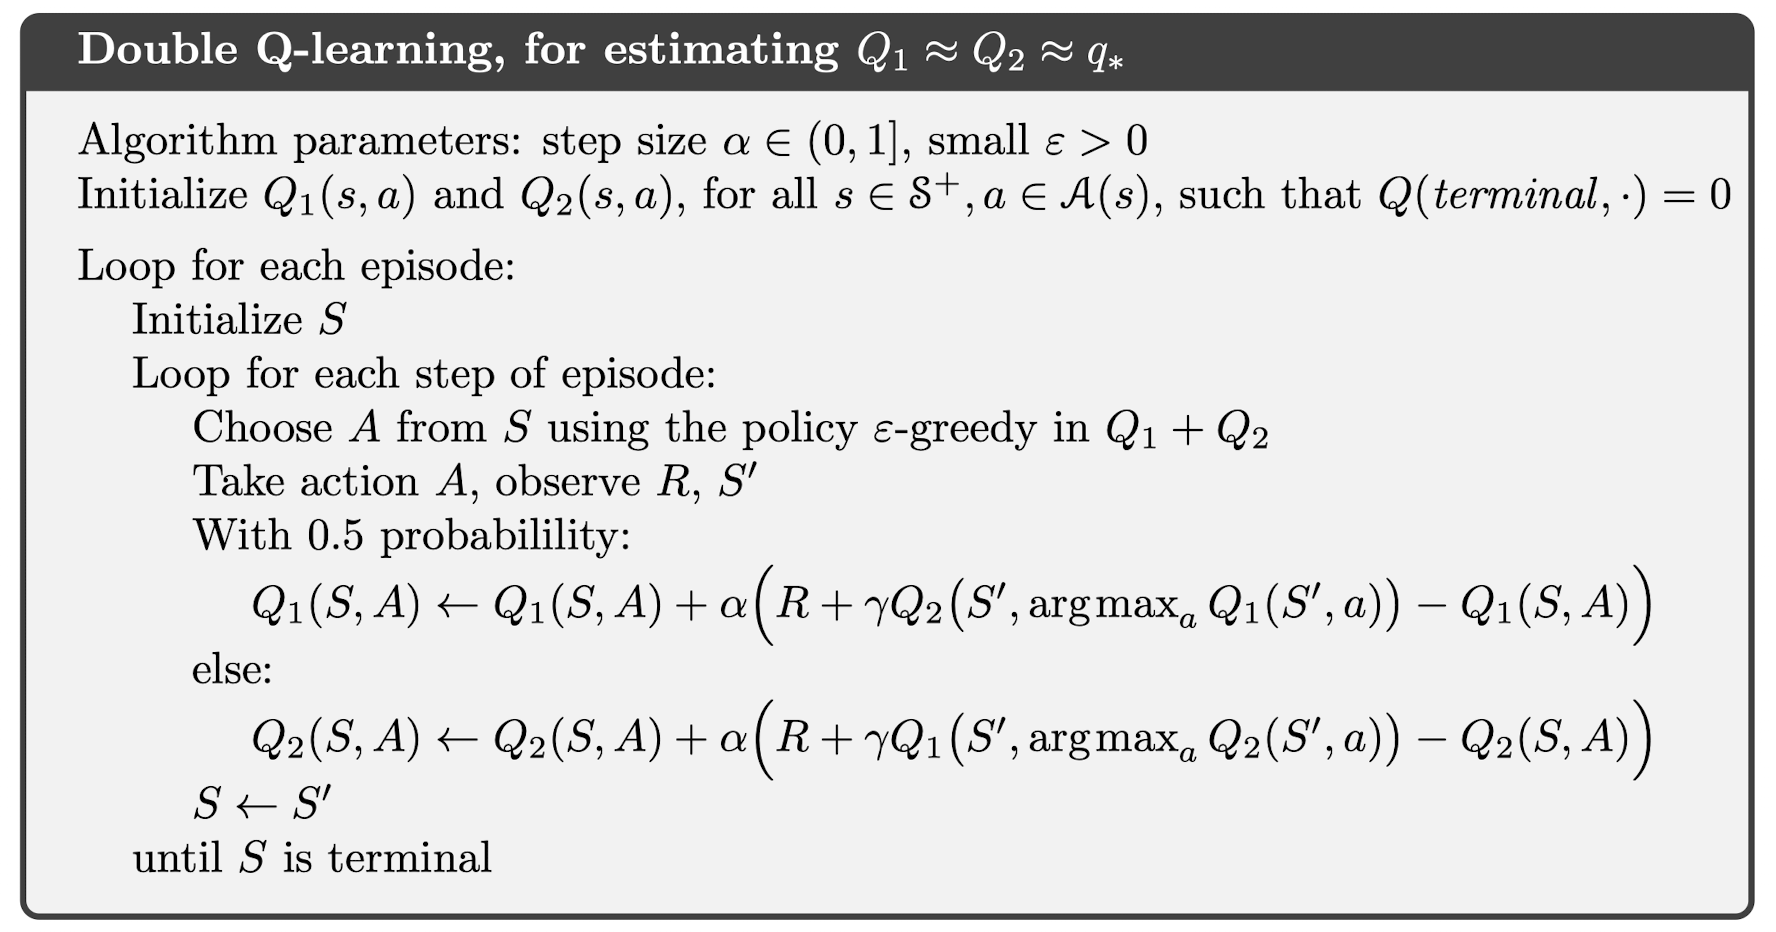

In [6]:
class DoubleQAgent(Agent):
  def __init__(self, state_space: Discrete, action_space: Discrete, discount_rate: float, epsilon:float, step_size:float):
    super().__init__(state_space, action_space, discount_rate) 
    self._epsilon = epsilon
    self._step_size = step_size 
    # action values
    self._Q1 = np.random.rand(state_space.n, action_space.n) #np.full((state_space.n, action_space.n), 0.0) 
    self._Q2 = np.random.rand(state_space.n, action_space.n) #np.full((state_space.n, action_space.n), 0.0) 
    # policy
    self._policy = get_epsilon_greedy_policy_from_action_values(self._Q1+self._Q2, self._epsilon)

  # get an action from policy
  def sample_action(self, state):
    return np.random.choice(len(self._policy[state]), p = self._policy[state])

  # update action value and policy 
  def control(self, state, action, reward, new_state, terminal):
    if random.random() < 0.5:
      Q1 = self._Q1
      Q2 = self._Q2
    else:
      Q1 = self._Q2
      Q2 = self._Q1

    if terminal:
      Q1[state][action] += self._step_size * (reward - Q1[state][action])
    else:
      # update Q value
      returns = Q2[new_state, np.argmax(Q1[new_state])]
      Q1[state][action] += self._step_size * (reward + self._discount_rate * returns - Q1[state][action])
    # update policy
    self._policy[state] = get_epsilon_greedy_policy_from_action_values(Q1[state]+Q2[state], self._epsilon) 

def test_double_q_agent():
  np.random.seed(0)
  agent = DoubleQAgent(
    state_space=Discrete(4), 
    action_space=Discrete(4), 
    discount_rate=1.0,
    epsilon=1.0,
    step_size=1.0,
  )
  state = 1
  action = 1
  agent._Q1[state, action] = 5
  agent._Q2[state, action] = 5
  agent._policy[state] = np.full(4, 0.0)
  agent._policy[state, action] = 1.0
  reward = 1.0
  new_state = 1
  new_action = agent.control(state, action, reward, new_state, False)
  np.testing.assert_almost_equal(agent._Q1[state,action] + agent._Q2[state,action], 11)
  print("test_double_q_agent passed!")
  
test_double_q_agent() 

test_double_q_agent passed!


In [7]:
def play_episode(agent: Agent, env: gym.Env, learning: Optional[bool] = True):
  state = env.reset()
  terminal = False
  steps = 0
  while not terminal:
    action = agent.sample_action(state)
    new_state, reward, terminal, info = env.step(action)
    if learning:
      agent.control(state, action, reward, new_state, terminal)
    state = new_state
    steps += 1
  return reward, steps 


 20%|██        | 101/500 [00:20<01:11,  5.57it/s]

step: 100, total reward: 0.0, avarage reward per step: 0.0


 40%|████      | 201/500 [00:41<00:55,  5.41it/s]

step: 200, total reward: 14.0, avarage reward per step: 0.013389897021610577


 60%|██████    | 302/500 [00:57<00:24,  8.20it/s]

step: 300, total reward: 35.0, avarage reward per step: 0.03759398496240601


 80%|████████  | 401/500 [01:09<00:10,  9.64it/s]

step: 400, total reward: 117.0, avarage reward per step: 0.03313362381989833


100%|██████████| 500/500 [01:21<00:00,  6.16it/s]
  result = np.fromstring(s, dtype='uint8')




rewarding episodes: 208.0


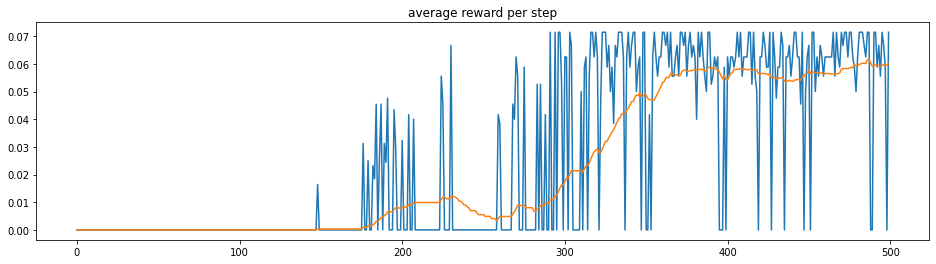

In [9]:
### Off policy learning ###
# Create Environment.
#env = gym.make('Taxi-v3')
reset_agent = True
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False)
directory = './video'
env = Recorder(env, directory)
if reset_agent == True:
  agent = DoubleQAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9,
    epsilon=0.1,
    step_size=0.5
  )
  history = []
  total_reward = 0

# start playing
max_episode = 500
for i in tqdm(range(max_episode)):
  reward, steps = play_episode(agent, env)
  history.append(reward / steps)
  total_reward += reward
  if i % 100 == 0 and i != 0:
    print(f"step: {i}, total reward: {total_reward}, avarage reward per step: {np.mean(history[-10:-1])}")

# udpate policy
agent._policy = get_epsilon_greedy_policy_from_action_values(agent._Q1+agent._Q2) 
play_episode(agent, env, learning=False)


print(f"\nrewarding episodes: {total_reward}")
plot_history(history)
env.play()


[[b'RIGH' b'RIGH' b'RIGH' b'DOWN' b'RIGH' b'RIGH' b'RIGH' b'DOWN']
 [b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'DOWN']
 [b'DOWN' b'DOWN' b'DOWN' b'RIGH' b'UP' b'UP' b'RIGH' b'DOWN']
 [b'DOWN' b'UP' b'RIGH' b'RIGH' b'DOWN' b'RIGH' b'RIGH' b'DOWN']
 [b'UP' b'RIGH' b'LEFT' b'UP' b'DOWN' b'RIGH' b'RIGH' b'DOWN']
 [b'RIGH' b'UP' b'UP' b'UP' b'RIGH' b'LEFT' b'DOWN' b'DOWN']
 [b'DOWN' b'RIGH' b'RIGH' b'DOWN' b'UP' b'DOWN' b'RIGH' b'DOWN']
 [b'RIGH' b'UP' b'UP' b'LEFT' b'UP' b'RIGH' b'RIGH' b'UP']]


Text(0.5, 1.0, 'state_values')

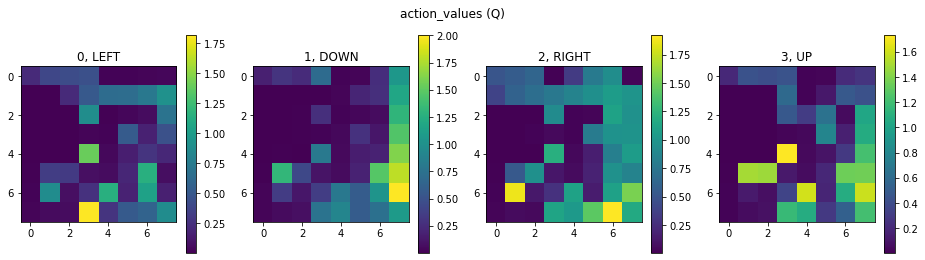

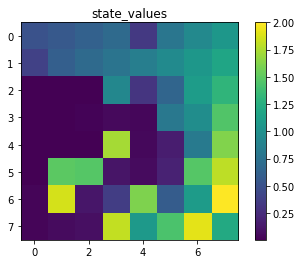

In [10]:
# Plot the action values.
# cliff walking
#shape = (4,12,4)
# frozen lake
## small
#shape = (4,4,4)
## large
shape = (8,8,4)
direction = {
  0:"LEFT",
  1:"DOWN",
  2:"RIGHT",
  3:"UP"
}
actions = np.argmax(agent._policy, axis=1)
actions = actions.reshape(shape[:2])
named_actions = np.chararray(actions.shape, itemsize=4)
map = [[""] * shape[1]] * shape[0]
for idx, val in np.ndenumerate(actions):
  named_actions[idx] = direction[val]
  #map[idx[0]][idx[1]] = direction[val]
print(named_actions)
agent._Q = agent._Q1+agent._Q2

action_values = agent._Q.reshape(shape)
num_actions = action_values.shape[-1]
plt.figure(2, figsize=(16,4))
plt.suptitle("action_values (Q)")
for i in range(num_actions):
  plt.subplot(1, num_actions,i+1)
  plt.title(f"{i}, {direction[i]}")
  plt.imshow(action_values[:,:,i])
  plt.colorbar(orientation='vertical')
  #print(action_values[:,:,i])


plt.figure(3)
state_values = get_state_values_from_action_values(agent._Q, agent._policy)
plt.imshow(state_values.reshape(shape[:2]))
plt.colorbar(orientation='vertical')
plt.title("state_values")


# Summary

## Tempro Difference Off-policy learning
The advantage of off policy learning is that the target policy is different from behavior policy. For TD:
1. Target policy is implicitly represented by action values `_Q`
2. Behavior policy is calcualted by applying epsilon greedy on action values `_Q`

The learned action-value function, `_Q`, directly approximates `q*`, the optimal action-value function, independent of the policy being followed. 

### Q-Learning
Q-learning use `R + max_a(Q(next_state, a)` to represent the future returns, which is independent of the policy being followed.

### Expected Sarsa
Q-learning use `R + E_a(Q(next_state, a)`(where `a` can follow any policy) to represent the future returns.



> Is Expected Sarsa considered off-policy?

> Expected SARSA can be used either on-policy or off-policy. The policy used in the update step determines which it is. If the update step uses a different weighting(target policy) for action choices than the policy that actually took the action(behavior policy), then you are using Expected SARSA in an off-policy way.

> Q-learning is a special case of Expected SARSA, where the target policy is greedy with respect to the action values, so there is only ever one 𝑟𝑡+1+𝛾max𝑎′𝑄(𝑠𝑡+1,𝑎′) term to add with a probability 1.

> link: https://ai.stackexchange.com/questions/20419/is-expected-sarsa-an-off-policy-or-on-policy-algorithm#:~:text=Expected%20SARSA%20can%20be%20used,in%20an%20off%2Dpolicy%20way. 



